## Notebook to implement AB testing after Model Evaluation

In [1]:
!rm -rf InkubaLM-Challenge
!git clone https://github.com/melissafasol/InkubaLM-Challenge.git
%cd InkubaLM-Challenge


Cloning into 'InkubaLM-Challenge'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 150 (delta 91), reused 86 (delta 36), pack-reused 0 (from 0)
Receiving objects: 100% (150/150), 730.04 KiB | 2.05 MiB/s, done.
Resolving deltas: 100% (91/91), done.
/content/InkubaLM-Challenge


In [83]:
%cd InkubaLM-Challenge
!git pull


[Errno 2] No such file or directory: 'InkubaLM-Challenge'
/content/InkubaLM-Challenge
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 401 bytes | 401.00 KiB/s, done.
From https://github.com/melissafasol/InkubaLM-Challenge
   45f2d0c..13a7923  main       -> origin/main
Updating 45f2d0c..13a7923
Fast-forward
 utils/ab_testing.py | 5 +++--
 1 file changed, 3 insertions(+), 2 deletions(-)


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
!pip install -U trl bitsandbytes
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335.7/335.7 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [85]:
import sys
sys.path.append("..")  # Add parent directory to the path

import os
from typing import List
from pathlib import Path
import numpy as np

# DO NOT EDIT
# create submission file
import pandas as pd
from huggingface_hub import login
from transformers import (
    AutoTokenizer,
)
from utils import (
    eval,
    model_function,
    multitask,
    experiment_logger,
    new_model_function,
    ab_testing
    )

import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, concatenate_datasets, Dataset, Value, DatasetDict

from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM
from peft import PeftModel, PeftConfig
from sklearn.model_selection import train_test_split




In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
output_path = "/content/drive/MyDrive/InkubaLM-Challenge/Output"
os.makedirs(output_path, exist_ok=True)

In [9]:
#os.environ["TOKENIZERS_PARALLELISM"] = "false"

from huggingface_hub import login

try:
    from google.colab import userdata

    # Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
    # vars as appropriate for your system.
    # userdata.get("HF_TOKEN") indicates that the name of the token in the Colab env is HF_TOKEN
    os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
except:
    os.environ["HF_TOKEN"] = "----"

login(token=os.environ["HF_TOKEN"])

token = os.environ["HF_TOKEN"]
if token == "----":
    print("⚠️ Warning: No Hugging Face token found. Some models may not load.")
else:
    login(token=token)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [10]:

print("# Loading datasets")
train_dataset = multitask.load_and_combine_datasets("Train")
test_dataset = multitask.load_and_combine_datasets("Test")

print("\n# Example from training dataset:")
print(train_dataset[0])

print("\n# Example from test dataset:")
print(test_dataset[0])

print("# Converting to DataFrame and extracting task types")
train_df = train_dataset.to_pandas()
train_df['task'] = train_df.ID.apply(multitask.extract_task_from_id)

print("\n# Dataset distribution by task:")
print(train_df.task.value_counts())



# Loading datasets


README.md:   0%|          | 0.00/485 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/39.0k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/485 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/72.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/600 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/447 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/35.0k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400 [00:00<?, ? examples/s]

Common Columns: ['instruction', 'targets', 'langs', 'ID', 'inputs']


Casting the dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/600 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/486 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/33.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/300 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/484 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/22.4k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/300 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/447 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/28.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/300 [00:00<?, ? examples/s]

Common Columns: ['instruction', 'targets', 'langs', 'ID', 'inputs']


Casting the dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/300 [00:00<?, ? examples/s]


# Example from training dataset:
{'ID': 'ID_6aba33a1_sentiment_ dev_hausa', 'langs': 'hausa', 'instruction': 'Za ka iya tantance yanayin wannan rubutu? Bi waɗannan jagororin sharhi: Kyakkyawa: idan rubutu na nuna kyakkyawan tunani, hali, da yanayi. Korau: idan rubutu yana nuna mummunar tunani ko yanayi. Neutral: idan rubutu baya nuna kyakkyawar magana ko mara kyau kai tsaye ko a kaikaice.', 'inputs': '@user @user allah ya tsayyaba yar uwa 🎂 😍', 'targets': 'Kyakkyawa'}

# Example from test dataset:
{'ID': 'ID_f3c74c7b_sentiment_test__hausa', 'langs': 'hausa', 'instruction': "Gano ra'ayin da aka bayyana a cikin wannan rubutu. Bin waɗannan jagororin, kyakkyawa yana na rubutu na nufin kyakkyawan tunani, ɗabi'a, da motsin rai. Korau na nuna rubutu na nufin mummunan tunani ko motsin rai. Tsaka-tsaki na nuna rubutu baya nufin magana mai kyau ko mara kyau kai tsaye ko a kaikaice.", 'inputs': '@user ynxu fha da kanada kudi shikenan duk kayan nan zasu iya zama naka no🧢', 'targets': None}
# Conv

## Still balancing dataset

## Load the original base model

In [11]:

from transformers import BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # or load_in_8bit=True for 8-bit quantization
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",  # or "fp4"
    bnb_4bit_compute_dtype=torch.bfloat16  # or torch.float16, depending on your hardware
)

model_name = "lelapa/InkubaLM-0.4B"
model, tokenizer, bnb_config = multitask.setup_model_and_tokenizer(model_name)

model = multitask.apply_lora_adapters(model)

tokenizer_config.json:   0%|          | 0.00/960 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/991k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.95M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/763 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.66G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

trainable params: 524,288 || all params: 664,684,544 || trainable%: 0.0789


In [12]:
from transformers import AutoTokenizer
tok = AutoTokenizer.from_pretrained(model_name)
balanced_df = multitask.balance_target_lengths(train_df, tokenizer=lambda x: tok.tokenize(x))

print("\n# Analyzing target sequence lengths after balancing")
task_stats_after = multitask.analyze_task_lengths(balanced_df)

balanced_dataset = Dataset.from_pandas(balanced_df.reset_index(drop=True))


# Analyzing target sequence lengths after balancing
Target sequence length analysis by task:
Task: sentiment
count    400.0000
mean       7.0125
std        2.0756
min        4.0000
25%        5.0000
50%        7.5000
75%        9.0000
max        9.0000
Name: targets, dtype: float64
--------------------------------------------------
Task: mt
count    600.000000
mean      11.801667
std        8.347163
min        2.000000
25%        6.000000
50%       10.000000
75%       15.000000
max       62.000000
Name: targets, dtype: float64
--------------------------------------------------
Task: afrixnli
count    400.0
mean      18.0
std        0.0
min       18.0
25%       18.0
50%       18.0
75%       18.0
max       18.0
Name: targets, dtype: float64
--------------------------------------------------


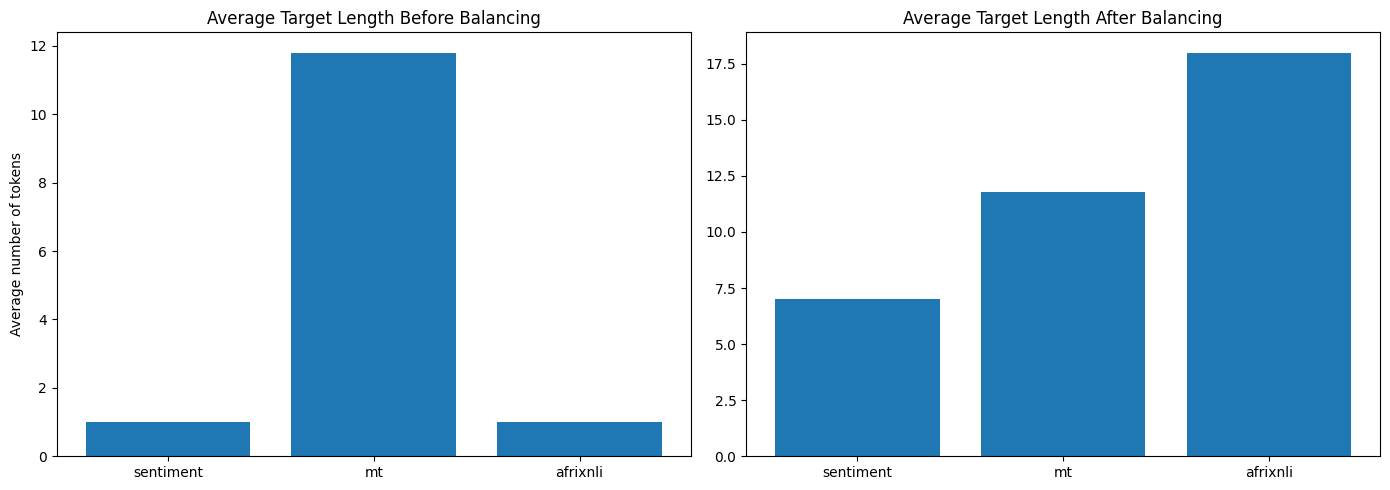

In [13]:
#testing balancing dataset more dynamically
multitask.plot_target_lengths(train_df, balanced_df)

## Splitting dataset into training and validation

In [103]:
# Stratified split (optional): to preserve task distribution
train_df_split, val_df_split = train_test_split(
    balanced_df,
    test_size=0.1,
    stratify=balanced_df["task"],
    random_state=42
)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df_split.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df_split.reset_index(drop=True))





In [100]:
from collections import Counter

# Check overall task distribution
print("Task distribution:")
print(Counter(train_df_split["task"]))

# For sentiment task — check class label balance per language
print("\nSentiment class distribution (Swahili):")
print(Counter(train_df_split[(train_df_split["task"] == "sentiment") &
                             (train_df_split["langs"] == "swahili")]["targets"]))

print("\nSentiment class distribution (Hausa):")
print(Counter(train_df_split[(train_df_split["task"] == "sentiment") &
                             (train_df_split["langs"] == "hausa")]["targets"]))


Task distribution:
Counter({'mt': 540, 'sentiment': 360, 'afrixnli': 360})

Sentiment class distribution (Swahili):
Counter({'Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani ': 115, 'Chanya Chanya Chanya Chanya Chanya Chanya Chanya Chanya Chanya ': 39, 'Hasi Hasi Hasi Hasi Hasi Hasi Hasi Hasi Hasi ': 24})

Sentiment class distribution (Hausa):
Counter({'Korau Korau Korau Korau Korau Korau ': 65, 'Tsaka-tsaki Tsaka-tsaki Tsaka-tsaki Tsaka-tsaki ': 61, 'Kyakkyawa Kyakkyawa Kyakkyawa Kyakkyawa Kyakkyawa ': 56})


In [101]:
print("\n[VAL] Sentiment class distribution (Swahili):")
print(Counter(val_df_split[(val_df_split["task"] == "sentiment") &
                           (val_df_split["langs"] == "swahili")]["targets"]))



[VAL] Sentiment class distribution (Swahili):
Counter({'Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani ': 9, 'Chanya Chanya Chanya Chanya Chanya Chanya Chanya Chanya Chanya ': 9, 'Hasi Hasi Hasi Hasi Hasi Hasi Hasi Hasi Hasi ': 4})


### Apply LoRA adapters

In [29]:
tok.pad_token = tok.eos_token


In [30]:

output_dir = "/content/drive/MyDrive/InkubaLM/outputs/best_model_dynamic_probabilistic_sampling"
os.makedirs(output_dir, exist_ok=True)
# Train
balanced_prob_trainer = multitask.setup_trainer_ab_testing(model, train_dataset, tokenizer=tok, output_dir=output_dir, val_dataset=val_dataset)
balanced_prob_trainer.train()

Applying formatting function to train dataset:   0%|          | 0/1260 [00:00<?, ? examples/s]

Converting train dataset to ChatML:   0%|          | 0/1260 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/1260 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1260 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1260 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/140 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/140 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/140 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/140 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/140 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss
10,4.010700,3.483903
20,3.204400,3.416911
30,3.665200,3.343147
40,3.358600,3.265754
50,3.141800,3.178820
60,3.038500,3.097216
70,2.959200,3.026018
80,2.988900,2.962298
90,3.164700,2.905453
100,2.827800,2.852103


TrainOutput(global_step=945, training_loss=2.405247025262742, metrics={'train_runtime': 1240.5776, 'train_samples_per_second': 3.047, 'train_steps_per_second': 0.762, 'total_flos': 1656597023539200.0, 'train_loss': 2.405247025262742})

In [ ]:
#save model
balanced_prob_trainer.save_model("outputs/best_model_dynamic_probabilistic")
tok.save_pretrained("outputs/best_model_dynamic_probabilistic")


# Load Trained Model with LoRA adapters


In [19]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel, PeftConfig

# Load base model
base_model = AutoModelForCausalLM.from_pretrained("lelapa/InkubaLM-0.4B", device_map="auto")

# Load LoRA adapter
lora_model = PeftModel.from_pretrained(
    base_model,
    "/content/drive/MyDrive/InkubaLM/outputs/best_model_dynamic_probabilistic"
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("lelapa/InkubaLM-0.4B")


In [96]:
from datasets import Dataset, DatasetDict
import pandas as pd

# --- Helper: Balance classes by downsampling ---
def balance_classes(df, label_col="targets"):
    min_class_count = df[label_col].value_counts().min()
    return df.groupby(label_col, group_keys=False).sample(n=min_class_count, random_state=42)

# --- Load and normalize Sentiment data ---
sentiment_train_df = pd.read_parquet("hf://datasets/lelapa/SentimentTrain/data/train-00000-of-00001.parquet")
sentiment_train_df['langs'] = sentiment_train_df['langs'].str.lower().str.strip()  # Normalize

# Filter by language
hausa_df = sentiment_train_df[sentiment_train_df['langs'] == 'hausa']
swahili_df = sentiment_train_df[sentiment_train_df['langs'] == 'swahili']

# Balance only if needed
balanced_hausa_df = balance_classes(hausa_df)
balanced_swahili_df = balance_classes(swahili_df)

# Convert to HuggingFace datasets
hau_dataset_sent = Dataset.from_pandas(balanced_hausa_df.reset_index(drop=True))
swa_dataset_sent = Dataset.from_pandas(balanced_swahili_df.reset_index(drop=True))

# Combine
dataset_dict_sent = DatasetDict({
    "swahili": swa_dataset_sent,
    "hausa": hau_dataset_sent
})



## Inspect class distribution

In [98]:
from collections import Counter

# Check class distribution for Hausa
hausa_df = sentiment_train_df[sentiment_train_df['langs'] == 'hausa']
print("Hausa Sentiment:", Counter(hausa_df["targets"]))

# Check class distribution for Swahili
swahili_df = balanced_swahili_df[balanced_swahili_df['langs'] == 'swahili']
print("Swahili Sentiment:", Counter(swahili_df["targets"]))


Hausa Sentiment: Counter({'Korau': 72, 'Tsaka-tsaki': 67, 'Kyakkyawa': 61})
Swahili Sentiment: Counter({'Chanya': 28, 'Hasi': 28, 'Wastani': 28})


In [94]:
from collections import Counter
print(Counter(swa_dataset_sent["targets"]))



Counter({'Wastani': 124, 'Chanya': 48, 'Hasi': 28})


In [81]:
custom_base_prompt = (
    "You are a world-class language model that solves the following NLP task with clarity and precision.\n"
    "Use only the instruction below to complete the task.\n\n"
    "### Instruction:\n{}\n\n"
    "### Output:"
)


custom_instruction_map = {
    "sent": "Classify the sentiment as:\n"
    "0: Positive\n1: Neutral\n2: Negative\n\n"
"Output only the number 0, 1, or 2. Do not include words.",
    "xnli": "Determine whether the hypothesis is Entailment, Contradiction, or Neutral given the premise.",
    "mt": "Translate the sentence from {input_lang} to fluent, natural-sounding English."
}

ab_testing.run_inference_on_tasks(
    output_path=output_path,
    lora_model=lora_model,
    tokenizer=tokenizer,
    new_model_function=new_model_function,
    sample_size=50,
    instruction_map=custom_instruction_map,
    base_prompt_template=custom_base_prompt
)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



🔁 Running task: sent | Language: swahili


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


KeyboardInterrupt: 

In [86]:
submission_df = ab_testing.create_submission(output_path=output_path, test_flag=True)


Loading: /content/drive/MyDrive/InkubaLM-Challenge/Output/hau_sent_prediction_dev.csv
Loading: /content/drive/MyDrive/InkubaLM-Challenge/Output/swa_sent_prediction_dev.csv
Loading: /content/drive/MyDrive/InkubaLM-Challenge/Output/hau_mt_prediction_dev.csv
Loading: /content/drive/MyDrive/InkubaLM-Challenge/Output/swa_mt_prediction_dev.csv
Loading: /content/drive/MyDrive/InkubaLM-Challenge/Output/hau_xnli_prediction_dev.csv
Loading: /content/drive/MyDrive/InkubaLM-Challenge/Output/swa_xnli_prediction_dev.csv
                                              logits  Response      Targets
0  [-12.952404975891113, -8.339903831481934, -12....         1    Kyakkyawa
1  [-13.373512268066406, -8.560260772705078, -13....         1  Tsaka-tsaki
2  [-12.998430252075195, -8.127093315124512, -12....         1  Tsaka-tsaki
3  [-13.07550048828125, -8.124724388122559, -13.0...         1        Korau
4  [-12.985157012939453, -8.30947208404541, -12.9...         1        Korau
5  [-12.88282299041748, -7.97735

In [65]:
test_sent_swa = pd.read_csv('/content/drive/MyDrive/InkubaLM-Challenge/Output/swa_sent_prediction_dev.csv')

In [72]:
test_sent_swa.head()

,ID,Instruction,Input Text,Response,Log-Likelihood,Targets,Task,Langs
0,ID_dfb02831_sentiment_ dev_swahili,Classify the sentiment as:\n0: Positive\n1: Ne...,picha mbunge wa kilombero peter lijualikali ak...,1,"[[-12.57816219329834, -8.015897750854492, -12....",Wastani,sentiment,swahili
1,ID_ad1d9888_sentiment_ dev_swahili,Classify the sentiment as:\n0: Positive\n1: Ne...,swali zuri sana nawatafuta wajuzi wa mambo wat...,1,"[[-12.536504745483398, -8.21485424041748, -12....",Wastani,sentiment,swahili
2,ID_34eed91d_sentiment_ dev_swahili,Classify the sentiment as:\n0: Positive\n1: Ne...,pole sana kwa hilo ili uweze kuona mkeka wako ...,1,"[[-12.527798652648926, -8.157760620117188, -12...",Wastani,sentiment,swahili
3,ID_362e20eb_sentiment_ dev_swahili,Classify the sentiment as:\n0: Positive\n1: Ne...,balozi zetu kama haziwezi ku initiate na diasp...,1,"[[-12.522073745727539, -8.107202529907227, -12...",Wastani,sentiment,swahili
4,ID_87300f4d_sentiment_ dev_swahili,Classify the sentiment as:\n0: Positive\n1: Ne...,je unaitaka waambie coke waweke jina lako,1,"[[-12.490974426269531, -8.07419204711914, -12....",Wastani,sentiment,swahili


In [71]:

def process_likelihood(likelihood_str):
    clean_str = (
        likelihood_str.replace("tensor(", "").replace(")", "").strip()
        .replace("[[", "").replace("]]", "").strip()
        .replace(" device='cuda:0'", "").replace(" dtype=torch.float16", "").strip()
        .replace("tensor", "").strip()
        .replace(",,", ",")
    )
    return [float(x) for x in clean_str.split(",") if x.strip()]


In [74]:
test_sent_swa["logits"] = test_sent_swa["Log-Likelihood"].apply(process_likelihood)
test_sent_swa[["logit_pos", "logit_neu", "logit_neg"]] = pd.DataFrame(test_sent_swa["logits"].tolist(), index=test_sent_swa.index)

In [77]:
test_sent_swa

,ID,Instruction,Input Text,Response,Log-Likelihood,Targets,Task,Langs,logits,logit_pos,logit_neu,logit_neg
0,ID_dfb02831_sentiment_ dev_swahili,Classify the sentiment as:\n0: Positive\n1: Ne...,picha mbunge wa kilombero peter lijualikali ak...,1,"[[-12.57816219329834, -8.015897750854492, -12....",Wastani,sentiment,swahili,"[-12.57816219329834, -8.015897750854492, -12.5...",-12.578162,-8.015898,-12.573524
1,ID_ad1d9888_sentiment_ dev_swahili,Classify the sentiment as:\n0: Positive\n1: Ne...,swali zuri sana nawatafuta wajuzi wa mambo wat...,1,"[[-12.536504745483398, -8.21485424041748, -12....",Wastani,sentiment,swahili,"[-12.536504745483398, -8.21485424041748, -12.5...",-12.536505,-8.214854,-12.530954
2,ID_34eed91d_sentiment_ dev_swahili,Classify the sentiment as:\n0: Positive\n1: Ne...,pole sana kwa hilo ili uweze kuona mkeka wako ...,1,"[[-12.527798652648926, -8.157760620117188, -12...",Wastani,sentiment,swahili,"[-12.527798652648926, -8.157760620117188, -12....",-12.527799,-8.157761,-12.519818
3,ID_362e20eb_sentiment_ dev_swahili,Classify the sentiment as:\n0: Positive\n1: Ne...,balozi zetu kama haziwezi ku initiate na diasp...,1,"[[-12.522073745727539, -8.107202529907227, -12...",Wastani,sentiment,swahili,"[-12.522073745727539, -8.107202529907227, -12....",-12.522074,-8.107203,-12.513067
4,ID_87300f4d_sentiment_ dev_swahili,Classify the sentiment as:\n0: Positive\n1: Ne...,je unaitaka waambie coke waweke jina lako,1,"[[-12.490974426269531, -8.07419204711914, -12....",Wastani,sentiment,swahili,"[-12.490974426269531, -8.07419204711914, -12.4...",-12.490974,-8.074192,-12.485637
5,ID_6aba33a1_sentiment_ dev_swahili,Classify the sentiment as:\n0: Positive\n1: Ne...,muheshimiwa kwa majina naitwa rahma juma salum...,1,"[[-12.599037170410156, -8.484620094299316, -12...",Wastani,sentiment,swahili,"[-12.599037170410156, -8.484620094299316, -12....",-12.599037,-8.484620,-12.594447
6,ID_b1a98cc1_sentiment_ dev_swahili,Classify the sentiment as:\n0: Positive\n1: Ne...,leo tena leo hii kwenye masimulizi ya juzi jan...,1,"[[-12.532306671142578, -8.270723342895508, -12...",Wastani,sentiment,swahili,"[-12.532306671142578, -8.270723342895508, -12....",-12.532307,-8.270723,-12.526798
7,ID_ff196cf3_sentiment_ dev_swahili,Classify the sentiment as:\n0: Positive\n1: Ne...,aiseeee this is nonsense hivi ameongea baya ga...,1,"[[-12.557792663574219, -8.108314514160156, -12...",Hasi,sentiment,swahili,"[-12.557792663574219, -8.108314514160156, -12....",-12.557793,-8.108315,-12.552937
8,ID_42d49e96_sentiment_ dev_swahili,Classify the sentiment as:\n0: Positive\n1: Ne...,hatuwezi kusemea benki zingine lakini benki ye...,1,"[[-12.574917793273926, -8.138864517211914, -12...",Chanya,sentiment,swahili,"[-12.574917793273926, -8.138864517211914, -12....",-12.574918,-8.138865,-12.566010
9,ID_903649ef_sentiment_ dev_swahili,Classify the sentiment as:\n0: Positive\n1: Ne...,hii ni kazi ngumu sana ndugu yangu uliyofanya ...,1,"[[-12.608080863952637, -8.350409507751465, -12...",Wastani,sentiment,swahili,"[-12.608080863952637, -8.350409507751465, -12....",-12.608081,-8.350410,-12.600196


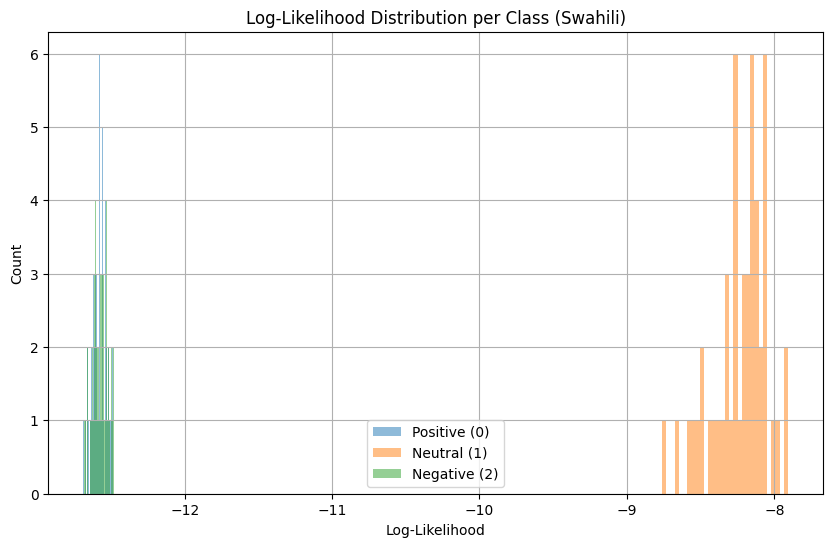

In [76]:
plt.figure(figsize=(10, 6))
plt.hist(test_sent_swa["logit_pos"], bins=30, alpha=0.5, label="Positive (0)")
plt.hist(test_sent_swa["logit_neu"], bins=30, alpha=0.5, label="Neutral (1)")
plt.hist(test_sent_swa["logit_neg"], bins=30, alpha=0.5, label="Negative (2)")
plt.title("Log-Likelihood Distribution per Class (Swahili)")
plt.xlabel("Log-Likelihood")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()


In [52]:
zindi_score, detailed_scores = eval.evaluate_zindi(os.path.join(output_path,"submission_test.csv"))

print("🔥 Zindi Score:", zindi_score)
print("📊 Breakdown:", detailed_scores)


🔥 Zindi Score: 0.1334217538637449
📊 Breakdown: {'sentiment_f1': np.float64(0.2252), 'nli_f1': np.float64(0.1728), 'mt_chrf': np.float64(0.0023), 'zindi_score': np.float64(0.1334)}


## Saving Model

In [45]:
balanced_prob_trainer.save_model("outputs/best_model_dynamic_probabilistic")
tok.save_pretrained("outputs/best_model_dynamic_probabilistic")

('outputs/best_model_dynamic_probabilistic/tokenizer_config.json',
 'outputs/best_model_dynamic_probabilistic/special_tokens_map.json',
 'outputs/best_model_dynamic_probabilistic/tokenizer.model',
 'outputs/best_model_dynamic_probabilistic/added_tokens.json',
 'outputs/best_model_dynamic_probabilistic/tokenizer.json')

In [46]:
balanced_prob_trainer.model.save_pretrained("/content/drive/MyDrive/InkubaLM/outputs/best_model_dynamic_probabilistic")


## Load balanced model with dynamic tokens

In [21]:
# Load base model
base_model = AutoModelForCausalLM.from_pretrained("lelapa/InkubaLM-0.4B", device_map="auto")

# Load LoRA adapter
lora_model = PeftModel.from_pretrained(
    base_model,
    "/content/drive/MyDrive/InkubaLM/outputs/best_model_dynamic_probabilistic"
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("lelapa/InkubaLM-0.4B")


In [13]:
results_df = multitask.apply_inference_to_test_data(lora_model, tokenizer, test_dataset)
results_df.to_csv("submission_test.csv", index=False)


Generating Responses:   0%|          | 0/900 [00:00<?, ?it/s]

In [15]:
results_df

,ID,langs,instruction,inputs,targets,generated,Response
0,ID_f3c74c7b_sentiment_test__hausa,hausa,Gano ra'ayin da aka bayyana a cikin wannan rub...,@user ynxu fha da kanada kudi shikenan duk kay...,None,👇 👇 👇 👇,0
1,ID_aad19dbf_sentiment_test__hausa,hausa,Za ka iya tantance yanayin wannan rubutu? Bi w...,@user alhamdulillah babu abinda zamuce sai god...,None,🙏 🙏 🙏 🙏,0
2,ID_f6de0381_sentiment_test__hausa,hausa,Za ka iya tantance yanayin wannan rubutu? Bi w...,@user ke ina ruwan ki 😬 ba harkar film bane ba,None,😬 😬 😬 😬,0
3,ID_cbec84fe_sentiment_test__swahili,swahili,Changanua mawazo ya matini yanayofuata na uain...,matokeo chanya liverais magufuli katika uzindu...,None,Wastani Wastani Wastani Wastani Wastani Wastan...,1
4,ID_885caf5c_sentiment_test__hausa,hausa,Tantance ra’ayin wannan rubutu kuma a rarraba ...,@user 🤣 akwai lauje cikin nadi gaskiya.,None,🤣 🤣 🤣 🤣,0
...,...,...,...,...,...,...,...
895,ID_88cd08fe_test__afrixnli_hau,hau,"Is the following question True, False or Neither?",Bradley ya fito daga Missouri.,None,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,0
896,ID_404bc9af_test__afrixnli_swa,swa,"Is the following question True, False or Neither?",Brahma ni sehemu muhimu zaidi ya utatu.,None,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,0
897,ID_a399ed32_test__afrixnli_swa,swa,"Is the following question True, False or Neither?",Ilinichukua muda wa miezi 13 kukiweka kichemsh...,None,1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1,1
898,ID_9f28a032_test__afrixnli_hau,hau,"Is the following question True, False or Neither?",an hada da nazarin Marxist-Leninist a harkar k...,None,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,0


In [18]:


def get_task_type(row):
    if "sentiment" in row["ID"]:
        return "sentiment"
    elif "xnli" in row["ID"]:
        return "nli"
    elif "mt" in row["ID"]:
        return "mt"
    else:
        return "unknown"

results_df["task"] = results_df.apply(get_task_type, axis=1)

In [78]:
results_df

NameError: name 'results_df' is not defined

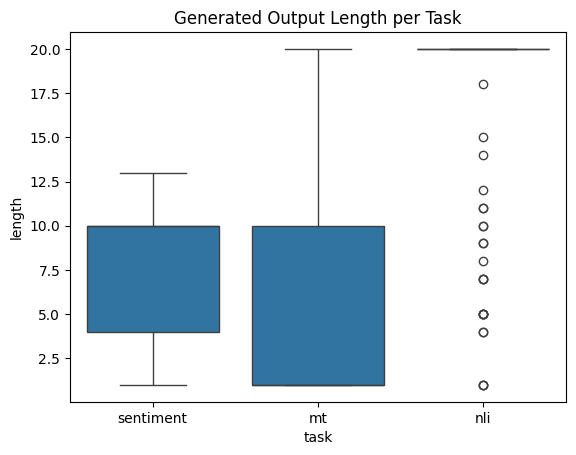

In [20]:

import seaborn as sns
import matplotlib.pyplot as plt

results_df["length"] = results_df["generated"].str.split().apply(len)

sns.boxplot(data=results_df, x="task", y="length")
plt.title("Generated Output Length per Task")
plt.show()


In [21]:

repetitive = results_df[results_df["generated"].str.contains(r"\b(\w+)( \1\b){3,}", regex=True, na=False)]
print(f"Repetitive outputs: {len(repetitive)} / {len(results_df)}")



Repetitive outputs: 529 / 900
